In [39]:
import pandas as pd
from vedo import Mesh, Plotter, Text2D

In [40]:
df_features = pd.read_csv("mesh_features.csv")
X = df_features.drop(["mesh_name", "class"], axis=1)
X.head()

,area,volume,rectangularity,compactness,convexity,eccentricity,diameter,A3_bin_0,A3_bin_1,A3_bin_2,...,D4_bin_center_20,D4_bin_center_21,D4_bin_center_22,D4_bin_center_23,D4_bin_center_24,D4_bin_center_25,D4_bin_center_26,D4_bin_center_27,D4_bin_center_28,D4_bin_center_29
0,2.567595,0.338307,0.401367,1.307688,0.859908,1.143945,1.033568,0.000000,0.001750,0.006999,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
1,3.314142,0.359405,0.391703,2.491678,0.836037,1.798762,1.047357,0.002276,0.007587,0.008346,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
2,3.172938,0.263182,0.677445,4.077757,1.562505,4.874752,1.000015,0.009857,0.018817,0.020609,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
3,0.561321,0.027836,0.217335,2.018231,0.610430,12.169459,0.999651,0.017274,0.024952,0.044146,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
4,0.671115,0.035075,0.251780,2.172427,0.686432,8.510702,0.998808,0.017117,0.028829,0.036036,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667


In [41]:
non_hist_features = ['area', 'volume', 'rectangularity', 'compactness', 'convexity', 'eccentricity', 'diameter']
hist_features = X.columns.difference(non_hist_features)
hist_features = hist_features[~(hist_features.str.contains('center'))]
grouped_columns = hist_features.groupby(hist_features.str[:2])
grouped_index_cols = {k: sorted([X.columns.get_loc(c) for c in v]) for k,v in grouped_columns.items()}
X[non_hist_features] = (X[non_hist_features] - X[non_hist_features].mean()) / X[non_hist_features].std()


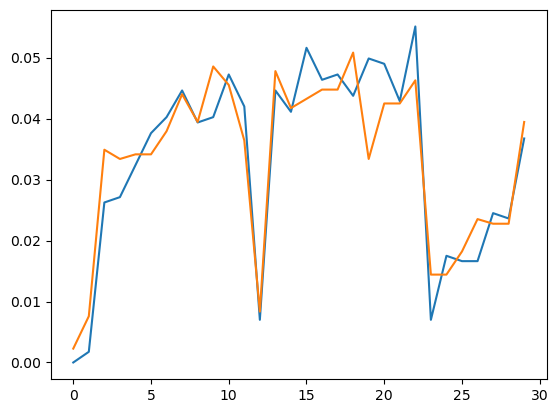

(np.float64(0.0025932519689464573), np.float64(0.0025932519689464573))

In [42]:
from scipy.stats import wasserstein_distance as emd
from matplotlib import pyplot as plt
import numpy as np

a3 = grouped_columns['A3']

u, v = X[a3].iloc[:2].to_numpy()
u.shape
# u, v
plt.plot(u)
plt.plot(v)
plt.show()
emd(u, v), emd(v, u) # def combined_dist(x, v):



In [43]:
def hist_distances(u, v, plot=False):
    dist = np.zeros(len(grouped_columns))
    for i, cols in enumerate(grouped_index_cols.values()):
        dist[i] = emd(u[cols], v[cols])
        if plot: 
            plt.plot(u[cols])
            plt.plot(v[cols])
            plt.show()
            print(i, dist[i])
    return dist

hist_distances(X.iloc[364].to_numpy(), X.iloc[147].to_numpy())


array([0.00262545, 0.00717358, 0.00469944, 0.00460239, 0.00683589])

In [44]:
def dist_func(u, v, weights = 1.):
    dist = np.zeros(len(non_hist_features) + len(grouped_columns))
    dist[:len(non_hist_features)] = np.abs(u[:len(non_hist_features)] - v[:len(non_hist_features)])
    dist[len(non_hist_features):] = hist_distances(u, v)

    return (weights * dist)

dist_func(X.iloc[364].to_numpy(), X.iloc[147].to_numpy()).sum()  # Car vs Biplane

np.float64(3.6857771361515743)

In [45]:
dist_func(X.iloc[0].to_numpy(), X.iloc[1].to_numpy()).sum()  # Two objects of the same class


np.float64(0.8669646773294263)

In [46]:
grouped_columns.keys()

dict_keys(['A3', 'D1', 'D2', 'D3', 'D4'])

In [148]:
def dist_plot(query_idx, idx, dist, df_features):

    pltr = Plotter((1, len(idx) + 1), size=[1000, 400])

    # Add the first mesh and its label
    mesh0 = Mesh(f"../normshapes/{df_features.loc[query_idx, 'class']}/{df_features.loc[query_idx, 'mesh_name']}")
    pltr.add(mesh0, at=0)
    pltr.parallel_projection(at=0)
    pltr.add(Text2D(f"Class= {df_features.loc[query_idx, 'class']}", pos=(0.1, 0.2), s=0.5), at=0)
    pltr.add(Text2D(f"Dist= {0.:.4f}", pos=(0.1, 0.17), s=0.5), at=0)
    pltr.add(Text2D(f"Mesh= {df_features.loc[query_idx, 'mesh_name']}", pos=(0.1, 0.14), s=0.5), at=0)

    # Add the rest of the meshes and their labels
    for j, i in enumerate(idx, start=1):
        mesh = Mesh(f"../normshapes/{df_features.loc[i, 'class']}/{df_features.loc[i, 'mesh_name']}")
        pltr.add(mesh, at=j)
        pltr.parallel_projection(at=j)

        pltr.add(Text2D(f"Class= {df_features.loc[i, 'class']}", pos=(0.1, 0.2), s=0.5), at=j)
        pltr.add(Text2D(f"Dist= {dist[j-1]:.4f}", pos=(0.1, 0.17), s=0.5), at=j)
        pltr.add(Text2D(f"Mesh= {df_features.loc[i, 'mesh_name']}", pos=(0.1, 0.14), s=0.5), at=j)

    return pltr

# pltr = dist_plot(t, best, dist, df_features)
# img = pltr.show()
# img.save("img/test.png")
# img


In [47]:
def retrieve_topk(x, others, k=4, weights=1.):
    dist = np.fromiter((dist_func(x, o, weights).sum() for o in others), dtype=x.dtype)
    return dist, dist.argsort()[:k]

X_np = X.to_numpy()
t = 851
best = retrieve_topk(X_np[t], X_np)
df_features[["mesh_name", "class"]].iloc[best]

,mesh_name,class
851,D01162.obj,Hand
867,m332.obj,Hand
1023,m359.obj,HumanHead
1015,m351.obj,HumanHead


In [50]:
from pynndescent import NNDescent
index = NNDescent(X_np)

In [51]:
idx, dist = index.query(X_np[[851]], k=4)
idx.shape, idx.flatten().shape
dist.shape

(1, 4)

In [109]:
from retrieval import RetrievalEngine

ret = RetrievalEngine()

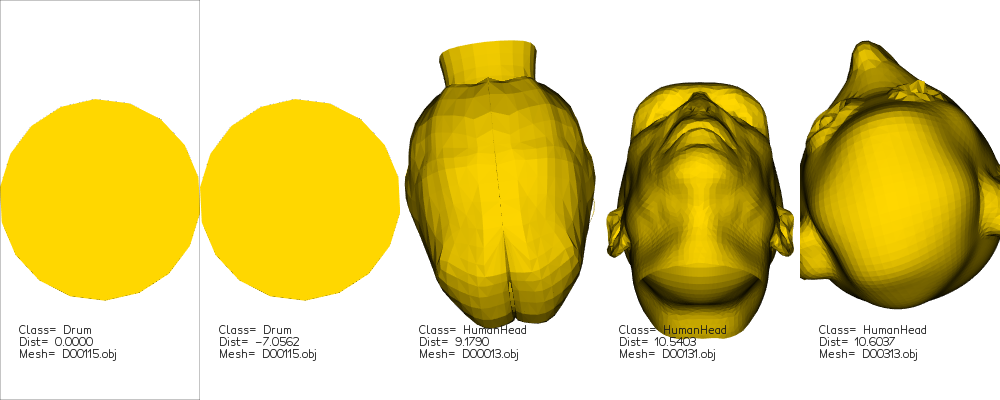

In [119]:
def test_customtopk(x, ret, k=4):
    dist = np.fromiter(
    (ret.dist_func(x, o).sum() for o in ret.X), dtype=x.dtype
    )
    topk_idx = dist.argsort()[:k]
    return topk_idx, dist[topk_idx]

t = 678
dist_plot(t, *test_customtopk(ret.X[t], ret), df_features=df_features).show()

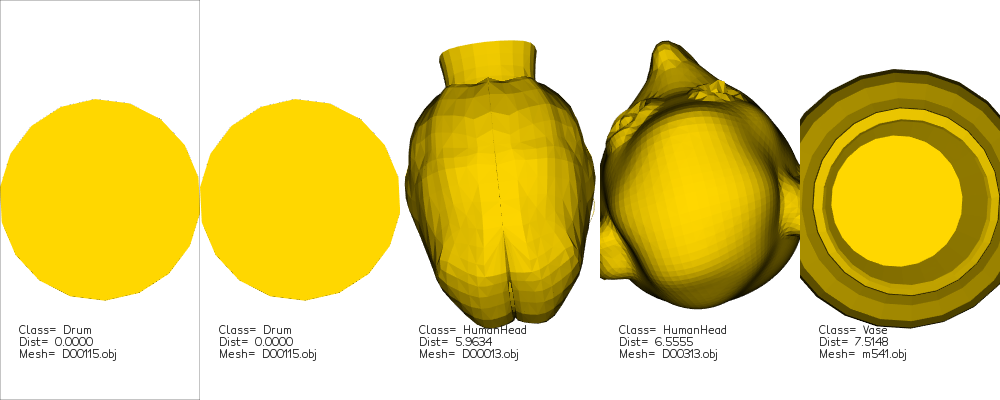

In [121]:
idx, dist = ret.index.query(ret.X[[t]], k=4)
dist_plot(t, idx.flatten(), dist.flatten(), df_features=df_features).show()

Custom distance function


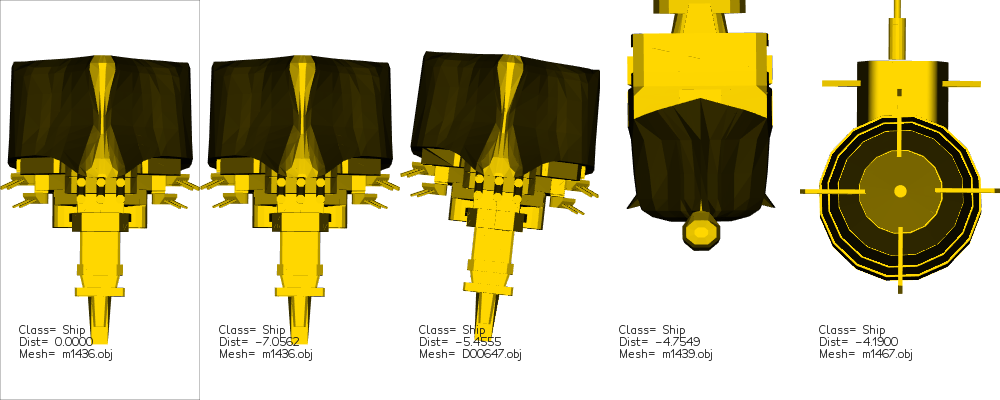

ANN with L2


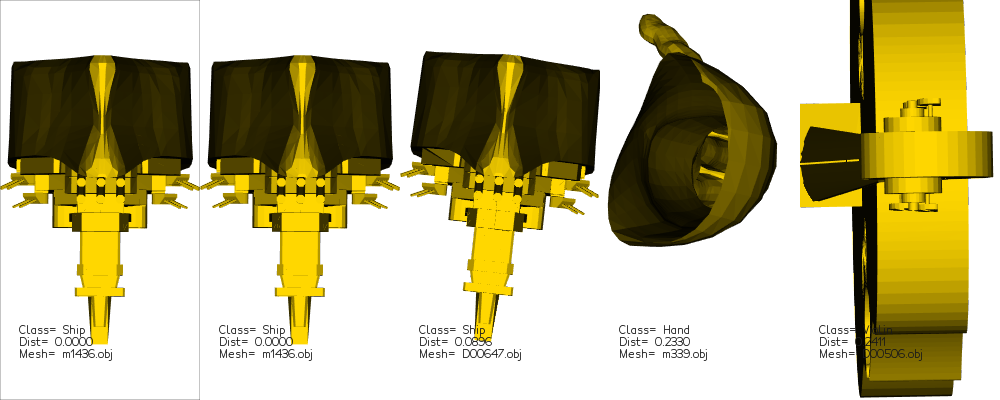

In [146]:
def test_t(t, ret=ret, df_features=df_features, show=True, k=4):
    custom_im = dist_plot(t, *test_customtopk(ret.X[t], ret, k=k), df_features=df_features).show()
    idx, dist = ret.index.query(ret.X[[t]], k=k)
    ann_im = dist_plot(t, idx.flatten(), dist.flatten(), df_features=df_features).show()
    
    if show:
        print("Custom distance function")
        custom_im.show()
        print("ANN with L2")
        ann_im.show()

    return custom_im, ann_im
     
a, b = test_t(2000)

Custom distance function


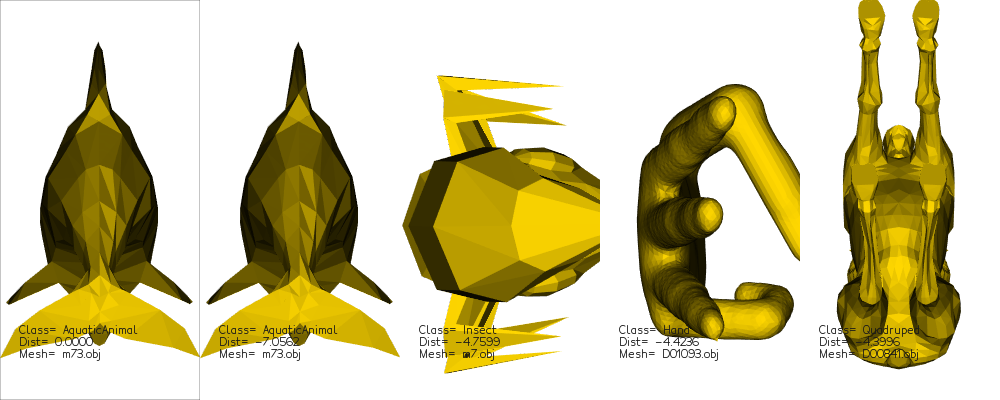

ANN with L2


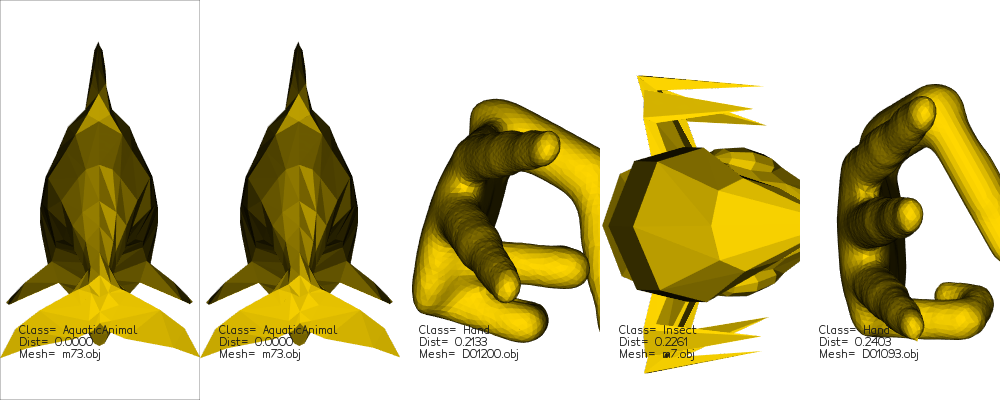

Custom distance function


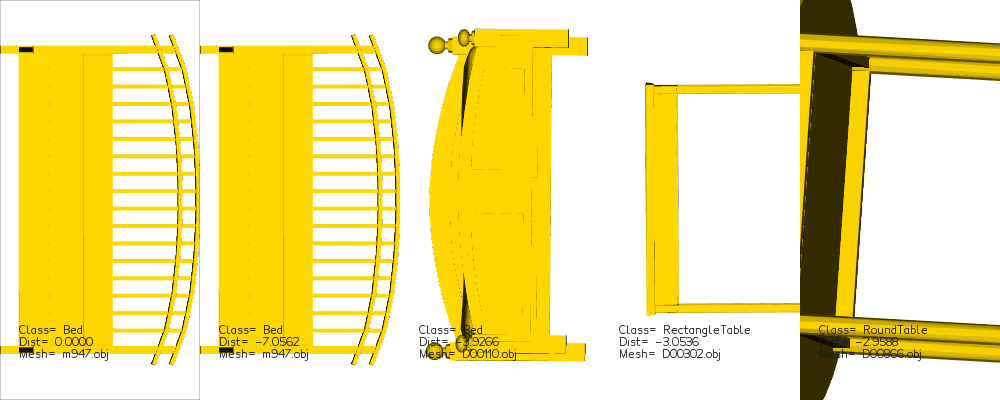

ANN with L2


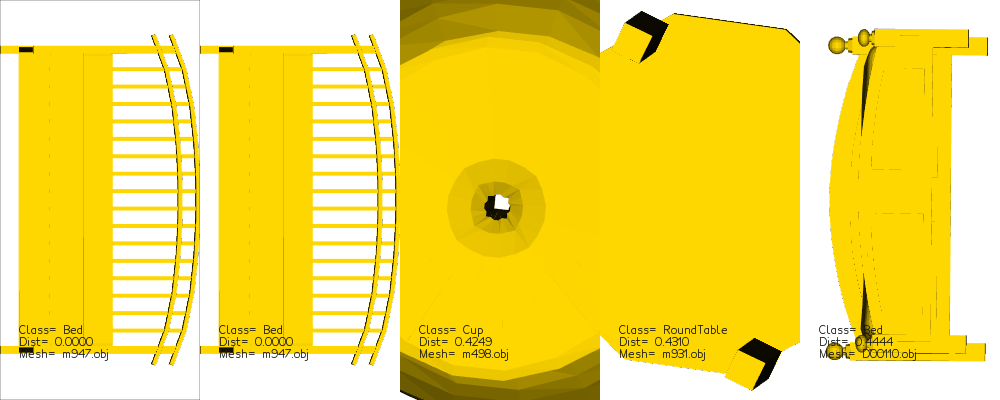

Custom distance function


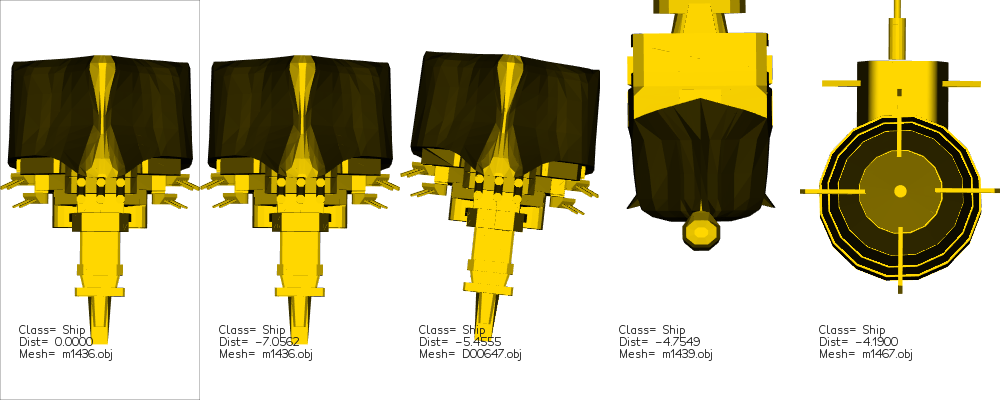

ANN with L2


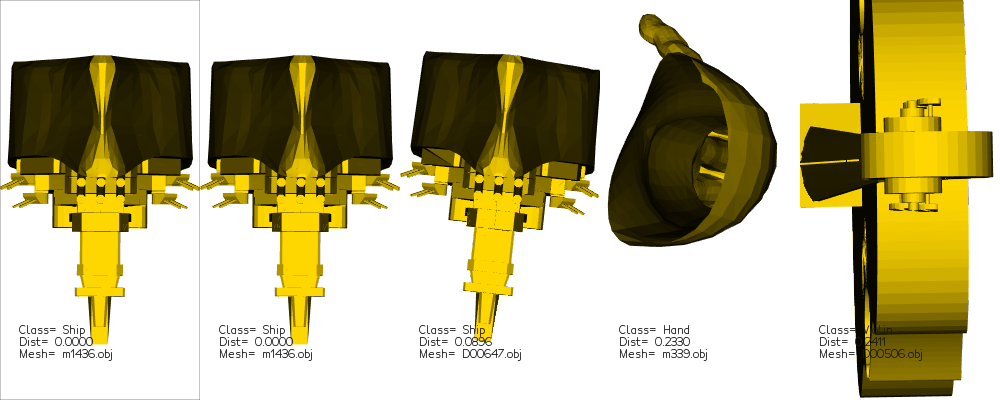

[(<PIL.Image.Image image mode=RGB size=1000x400>,
  <PIL.Image.Image image mode=RGB size=1000x400>),
 (<PIL.Image.Image image mode=RGB size=1000x400>,
  <PIL.Image.Image image mode=RGB size=1000x400>),
 (<PIL.Image.Image image mode=RGB size=1000x400>,
  <PIL.Image.Image image mode=RGB size=1000x400>)]

In [133]:
[test_t(t) for t in [58, 89, 2000]]

Custom distance function


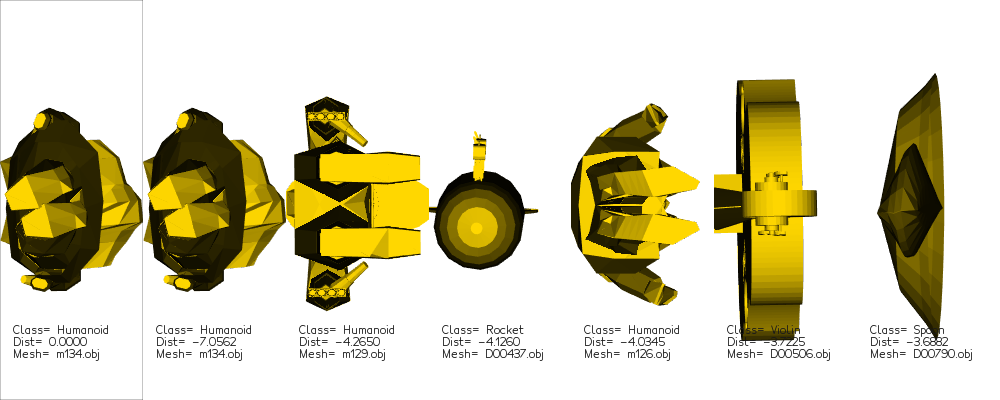

ANN with L2


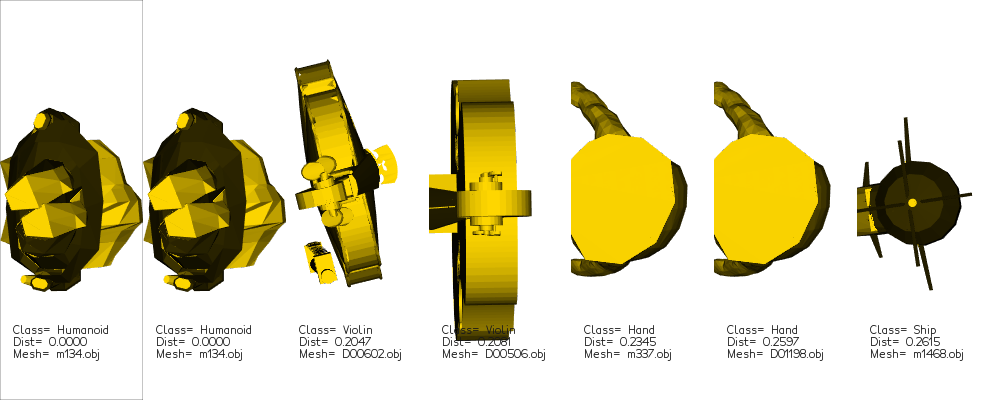

(<PIL.Image.Image image mode=RGB size=1000x400>,
 <PIL.Image.Image image mode=RGB size=1000x400>)

In [149]:
test_t(1049, k=6)

In [142]:
np.argwhere(df_features['mesh_name'] == 'm134.obj')

array([[1049]])

In [154]:
idx, dist = ret.index.query(ret.X, k=2419)
idx.shape

(2419, 2419)

In [161]:
idx_sort[0].shape

(2419,)

In [166]:
idx_sort = idx.argsort()
for i in range(2419):
    idx[i] = idx[i, idx_sort[i]]
    dist[i] = dist[i, idx_sort[i]]

idx[0], dist[0]

(array([   0,    1,    2, ..., 2416, 2417, 2418], dtype=int32),
 array([ 0.        ,  0.47589737,  0.98168427, ..., 32.595875  ,
        38.974022  , 49.090355  ], dtype=float32))

In [167]:
np.savez_compressed("ann_distances", idx=idx, dist=dist)

In [169]:
# idx, dist = zip(*(ret(x, k=2419) for x in ret.X[:10]))
from itertools import combinations
from tqdm import tqdm
from math import factorial
total = factorial(2419) / (2 * factorial(2419 - 2))

dist = np.zeros((2419, 2419))

for i, j in tqdm(combinations(range(2419), r=2), total=total):
    idist = ret.dist_func(ret.X[i], ret.X[j]).sum()
    dist[i, j] = idist
    dist[j, i] = idist

np.savez_compressed("custom_distances", dist=dist)


  0%|          | 0/2924571.0 [00:00<?, ?it/s]

100%|██████████| 2924571/2924571.0 [12:36<00:00, 3864.89it/s]


In [172]:
dist.argmin(axis=1)

array([   1,    0, 1003, ..., 1620, 2414, 2406])

In [180]:
X = ret.X 
# X.mean(axis=0), X.std(axis=0).shape

(array([-4.69974526e-17,  3.52480894e-17, -2.34987263e-17, -7.34335196e-18,
        -3.52480894e-17,  7.34335196e-18, -2.52611307e-15,  2.52146970e-02,
         3.71758144e-02,  4.02964956e-02,  4.16687585e-02,  4.17349899e-02,
         4.16457480e-02,  4.07990393e-02,  4.06416071e-02,  3.94842135e-02,
         3.86677896e-02,  3.76479088e-02,  3.70326836e-02,  3.60539850e-02,
         3.52775402e-02,  3.44736488e-02,  3.33900961e-02,  3.27341192e-02,
         3.19388731e-02,  3.12917164e-02,  3.06122374e-02,  2.99099903e-02,
         2.91402357e-02,  2.85023712e-02,  2.81275937e-02,  2.76192359e-02,
         2.69797499e-02,  2.63413194e-02,  2.57885887e-02,  2.51244065e-02,
         2.46845476e-02,  0.00000000e+00,  3.33333333e-02,  6.66666667e-02,
         1.00000000e-01,  1.33333333e-01,  1.66666667e-01,  2.00000000e-01,
         2.33333333e-01,  2.66666667e-01,  3.00000000e-01,  3.33333333e-01,
         3.66666667e-01,  4.00000000e-01,  4.33333333e-01,  4.66666667e-01,
         5.0

In [189]:
ret.metadata.iloc[[0, 1]]

,mesh_name,class
0,m1337.obj,AircraftBuoyant
1,m1338.obj,AircraftBuoyant


In [197]:
[row[1][0] for row in ret.metadata.iloc[[0, 1]].iterrows()]

/tmp/ipykernel_22713/2603371661.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [row[1][0] for row in ret.metadata.iloc[[0, 1]].iterrows()]


['m1337.obj', 'm1338.obj']